<center>
<h1>Proyecto Final - Coterminal</h1>
</center>

- Carlos Andrés Zuluaga Mora
- Ricardo Andrés Cortés Coronell
- Andrés Felipe Sánchez Rincón

## Requisitos de ejecución

- Cree un entorno Python (Versión 3.11 como mínimo) en su máquina mediante el comando `conda create -n {nombre del entorno}`.
- Instale todas las librerías faltantes con el comando `conda install {nombre de la librería}`. De presentarse el caso en el que dicho comando no funcione adecuadamente, recurra a opciones como `conda-forge` o `pip` para continuar con el proceso de instalación

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
import logging
import psycopg2


### Montaje del contenedor donde se alojará la base de datos

In [8]:
# Ejecutar un comando de docker compose
result = subprocess.run(
    ["docker", "compose", "up", "-d"],
    capture_output=True,
    text=True
)

# Ver salida
print("STDOUT:", result.stdout)
print("STDERR:", result.stderr)
print("Código de salida:", result.returncode)

STDOUT: 
STDERR: time="2025-09-01T18:44:34-05:00" level=warning msg="c:\\Users\\User\\OneDrive - Universidad de la Sabana\\Desktop\\Universidad\\2025-2\\Herramientas de Big Data (Énfasis)\\ProyectoBigData\\docker-compose.yml: the attribute `version` is obsolete, it will be ignored, please remove it to avoid potential confusion"
 Network proyectobigdata_default  Creating
 Network proyectobigdata_default  Created
 Container proyectobigdata-postgres-1  Creating
 Container proyectobigdata-postgres-1  Created
 Container proyectobigdata-postgres-1  Starting
 Container proyectobigdata-postgres-1  Started

Código de salida: 0


### Preparación y limpieza de datos

In [9]:
# Extraer información de archivo .csv
df_covid19 = pd.read_csv("estimated-cumulative-excess-deaths-per-100000-people-during-covid-19.csv")

# Limpieza de datos

# Eliminación de columnas no empleadas 
df_covid19.drop(columns=['Cumulative excess deaths per 100,000 people (95% CI, lower bound)', 
        'Cumulative excess deaths per 100,000 people (95% CI, upper bound)'], inplace=True)

# Cambio de nombres de columnas
df_covid19.rename(columns={
    'Entity': 'País',
    'Day': 'Fecha',
    'Cumulative excess deaths per 100,000 people (central estimate)': 'Exceso_Muertes',
    'Total confirmed deaths due to COVID-19 per 100,000 people': 'Muertes_Confirmadas_100k'
}, inplace=True)

# Convertir la columna 'Fecha' a datetime
df_covid19['Fecha'] = pd.to_datetime(df_covid19['Fecha'])

# La columna de muertes confirmadas tiene nulos al inicio. Asumimos que son 0.
df_covid19['Muertes_Confirmadas_100k'].fillna(0, inplace=True)

# Para el análisis, las filas sin una estimación central de exceso de muertes no son útiles.
df_covid19.dropna(subset=['País', 'Fecha', 'Exceso_Muertes'], inplace=True)


df_covid19.info()
df_covid19.head()

<class 'pandas.core.frame.DataFrame'>
Index: 55458 entries, 0 to 509042
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   País                      55458 non-null  object        
 1   Fecha                     55458 non-null  datetime64[ns]
 2   Exceso_Muertes            55458 non-null  float64       
 3   Muertes_Confirmadas_100k  55458 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 2.1+ MB


C:\Users\User\AppData\Local\Temp\ipykernel_25056\4277307290.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_covid19['Muertes_Confirmadas_100k'].fillna(0, inplace=True)


,País,Fecha,Exceso_Muertes,Muertes_Confirmadas_100k
0,Afghanistan,2020-01-01,-0.022148,0.0
1,Afghanistan,2020-01-06,-0.044295,0.0
2,Afghanistan,2020-01-13,-0.047579,0.0
3,Afghanistan,2020-01-20,0.022123,0.0
4,Afghanistan,2020-01-27,0.063374,0.0


### Creación de DB y cargue de información

In [10]:
import psycopg2

# === 1. Verificar/crear la base de datos ===
try:
    # Conexión a la base por defecto
    default_conn = psycopg2.connect(
        dbname="postgres",   # Base inicial por defecto
        user="psqluser",
        password="psqlpass",
        host="localhost",
        port="5433"
    )
    default_conn.autocommit = True  # Necesario para CREATE DATABASE

    with default_conn.cursor() as cur:
        cur.execute("SELECT 1 FROM pg_database WHERE datname = %s", ('covid19-project',))
        exists = cur.fetchone()
        if not exists:
            cur.execute('CREATE DATABASE "covid19-project";')
            print("Base de datos 'covid19-project' creada exitosamente.")
        else:
            print("La base de datos 'covid19-project' ya existe.")

except Exception as e:
    print(f"Error al crear la base de datos: {e}")
    raise

finally:
    if 'default_conn' in locals():
        default_conn.close()

# === 2. Conexión a la base 'covid19-project' ===
db_params = {
    'dbname': 'covid19-project',
    'user': 'psqluser',
    'password': 'psqlpass',
    'host': 'localhost',
    'port': '5433'
}

try:
    conn = psycopg2.connect(**db_params)
    cursor = conn.cursor()

    # === 3. Crear la tabla ===
    cursor.execute("DROP TABLE IF EXISTS muertes_covid19;")
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS muertes_covid19 (
            id SERIAL PRIMARY KEY,
            pais VARCHAR(100),
            fecha DATE,
            exceso_muertes INT,
            muertes_confirmadas INT
        )
    """)
    conn.commit()
    print("Tabla creada exitosamente.")

    # === 4. Preparar e insertar los datos desde tu DataFrame ===
    data = list(df_covid19[['País', 'Fecha', 'Exceso_Muertes', 'Muertes_Confirmadas_100k']].itertuples(index=False, name=None))

    cursor.executemany("""
        INSERT INTO muertes_covid19 (pais, fecha, exceso_muertes, muertes_confirmadas)
        VALUES (%s, %s, %s, %s)
    """, data)
    conn.commit()
    print(f"{len(data)} filas insertadas exitosamente en la tabla.")

except Exception as e:
    print(f"Error al insertar datos: {e}")
    raise

finally:
    if 'conn' in locals():
        conn.close()

La base de datos 'covid19-project' ya existe.
Tabla creada exitosamente.
55458 filas insertadas exitosamente en la tabla.


<center>
<h1>Sección de Análisis</h1>
</center>


### ¿Cómo evolucionaron las muertes confirmadas por COVID-19 a lo largo del tiempo en los 10 países más afectados?

19:35:50.546 | INFO    | Flow run 'boisterous-aardwolf' - Beginning flow run 'boisterous-aardwolf' for flow 'analyze-excess-deaths-flow'

C:\Users\User\AppData\Local\Temp\ipykernel_25056\23244089.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


19:35:50.692 | INFO    | Task run 'extract_from_db-92e' - Finished in state Completed()

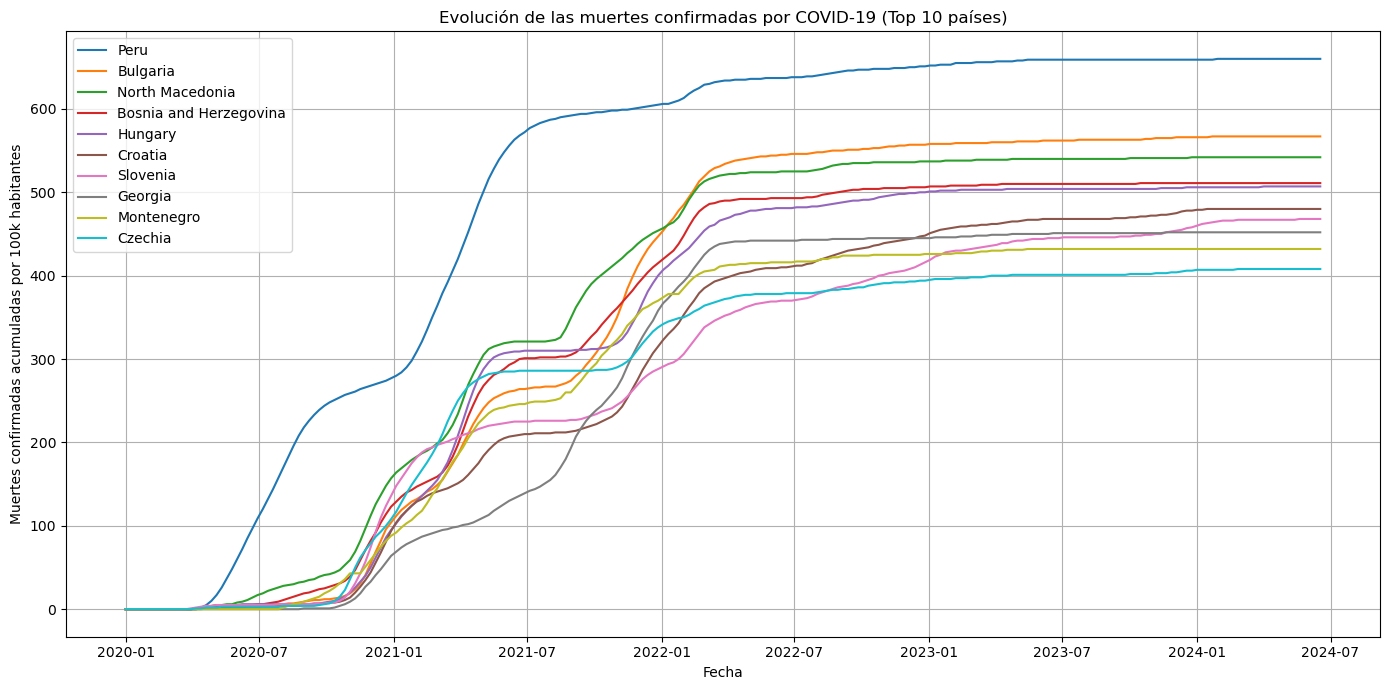

19:35:51.208 | INFO    | Task run 'plot_excess_deaths-9b1' - Finished in state Completed()

19:35:51.263 | INFO    | Flow run 'boisterous-aardwolf' - Finished in state Completed()

In [24]:
from prefect import flow, task, get_run_logger

db_params = {
    'dbname': 'covid19-project',
    'user': 'psqluser',
    'password': 'psqlpass',
    'host': 'localhost',
    'port': '5433'
}

@task
def extract_from_db(db_params, table_name="muertes_covid19"):
    logger = get_run_logger()
    try:
        conn = psycopg2.connect(**db_params)
        query = f"""
            SELECT "pais", "fecha", "muertes_confirmadas"
            FROM {table_name}
            WHERE "muertes_confirmadas" IS NOT NULL;
        """
        df = pd.read_sql(query, conn)
        conn.close()
        return df
    except Exception as e:
        logger.error(f"Error extrayendo datos de PostgreSQL: {e}")
        raise

@task
def plot_excess_deaths(df):
    # Asegurarse de que la columna fecha es datetime
    df['fecha'] = pd.to_datetime(df['fecha'])

    # Graficar todos los países (solo los principales para evitar saturación visual)
    top_countries = df.groupby('pais')['muertes_confirmadas'].max().sort_values(ascending=False).head(10).index
    plt.figure(figsize=(14, 7))
    for country in top_countries:
        country_data = df[df['pais'] == country]
        plt.plot(country_data['fecha'], country_data['muertes_confirmadas'], label=country)

    plt.title("Evolución de las muertes confirmadas por COVID-19 (Top 10 países)")
    plt.xlabel("Fecha")
    plt.ylabel("Muertes confirmadas acumuladas por 100k habitantes")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

@flow
def analyze_excess_deaths_flow():
    df = extract_from_db(db_params)
    plot_excess_deaths(df)

# Ejecutar el flow
analyze_excess_deaths_flow()

### ¿Cuál fue el comportamiento de Colombia a nivel de muertes confirmadas y muertes en exceso durante el periodo evaluado?

19:47:56.892 | INFO    | Flow run 'refreshing-eel' - Beginning flow run 'refreshing-eel' for flow 'analyze-excess-deaths-flow'

C:\Users\User\AppData\Local\Temp\ipykernel_25056\3445649882.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


19:47:56.990 | INFO    | Task run 'extract_from_db-231' - Finished in state Completed()

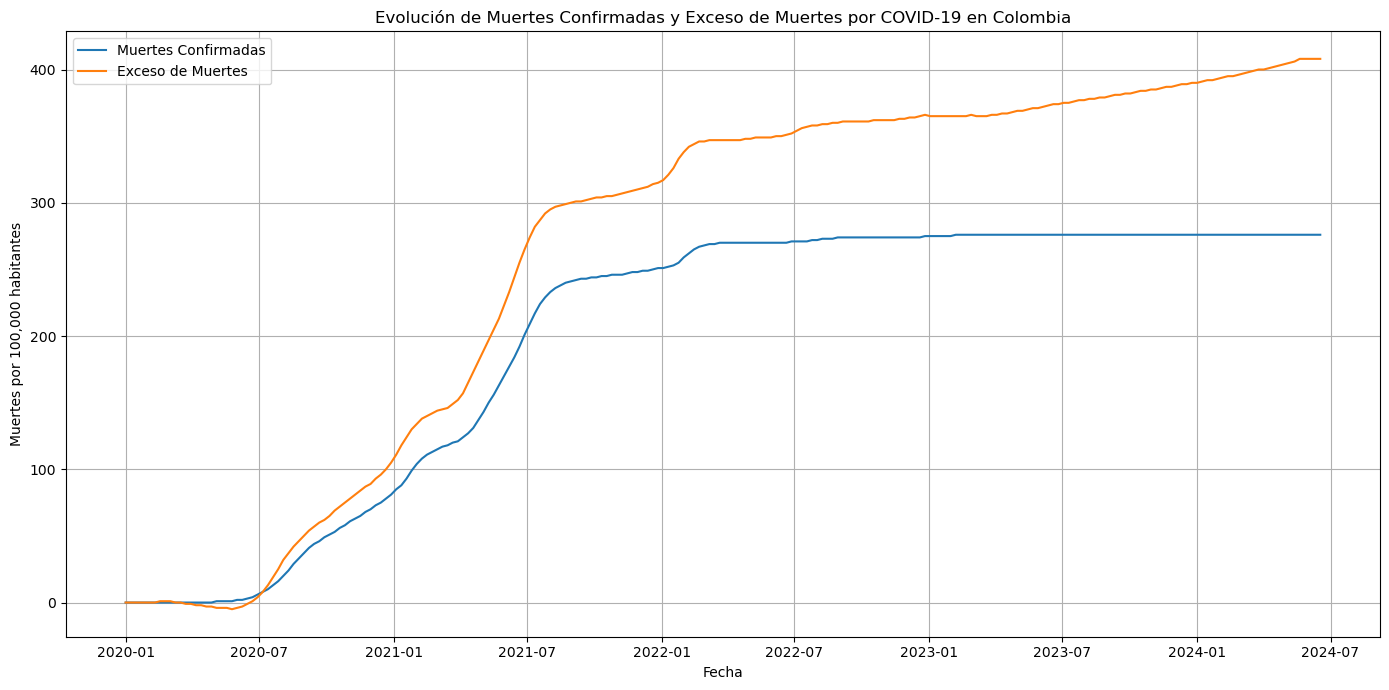

19:47:57.478 | INFO    | Task run 'plot_excess_deaths-78d' - Finished in state Completed()

19:47:57.536 | INFO    | Flow run 'refreshing-eel' - Finished in state Completed()

In [30]:
from prefect import flow, task, get_run_logger

db_params = {
    'dbname': 'covid19-project',
    'user': 'psqluser',
    'password': 'psqlpass',
    'host': 'localhost',
    'port': '5433'
}

@task
def extract_from_db(db_params, table_name="muertes_covid19"):
    logger = get_run_logger()
    try:
        conn = psycopg2.connect(**db_params)
        query = f"""
            SELECT "pais", "fecha", "muertes_confirmadas", "exceso_muertes"
            FROM {table_name}
            WHERE "muertes_confirmadas" IS NOT NULL AND "pais" = 'Colombia';
        """
        df = pd.read_sql(query, conn)
        conn.close()
        return df
    except Exception as e:
        logger.error(f"Error extrayendo datos de PostgreSQL: {e}")
        raise

@task
def plot_excess_deaths(df):
    # Asegurarse de que la columna fecha es datetime
    df['fecha'] = pd.to_datetime(df['fecha'])

    plt.figure(figsize=(14, 7))
    plt.plot(df['fecha'], df['muertes_confirmadas'], label='Muertes Confirmadas')
    plt.plot(df['fecha'], df['exceso_muertes'], label='Exceso de Muertes')
    plt.title('Evolución de Muertes Confirmadas y Exceso de Muertes por COVID-19 en Colombia')
    plt.xlabel('Fecha')
    plt.ylabel('Muertes por 100,000 habitantes')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

@flow
def analyze_excess_deaths_flow():
    df = extract_from_db(db_params)
    plot_excess_deaths(df)

# Ejecutar el flow
analyze_excess_deaths_flow()